In [91]:
import os
import pathlib
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

In [92]:
data_dir = "data"

In [93]:
total_images = 0
for root, _, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            total_images += 1
            image_path = os.path.join(root, file)

print("Total images downloaded:", total_images)


Total images downloaded: 317


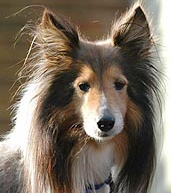

In [94]:
dog_path = pathlib.Path(data_dir) / "dog"
dog_imgs = list(dog_path.glob("*.jpg"))

Image.open(str(dog_imgs[0]))

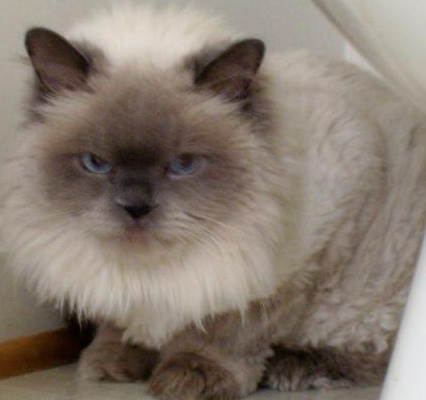

In [95]:
cat_path = pathlib.Path(data_dir) / "cat"
cat_imgs = list(cat_path.glob("*.jpg"))

Image.open(str(cat_imgs[0]))

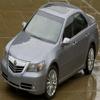

In [96]:
car_path = pathlib.Path(data_dir) / "car"
car_imgs = list(car_path.glob("*.jpg"))

Image.open(str(car_imgs[0]))

In [97]:
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [98]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split



dataset = ImageFolder(data_dir, transform=data_transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

In [99]:
print(len(train_dataset))

253


In [100]:
print(len(val_dataset))


64


In [101]:
class_names = dataset.classes
print(class_names)

['car', 'cat', 'dog']


In [102]:
train_dataloader = DataLoader(train_dataset, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..1.4896734].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.3472902..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8431373..1.9254032].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.6116778].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2989979..2.535425]

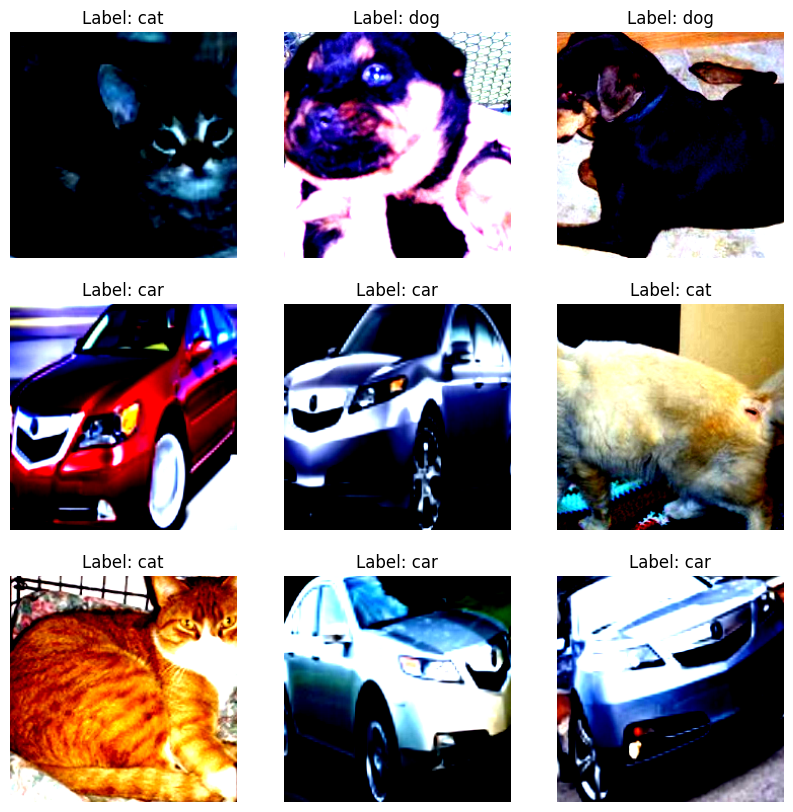

In [103]:
import matplotlib.pyplot as plt

data_iter = iter(train_dataloader)

images, labels = next(data_iter)

plt.figure(figsize=(10, 10))
for i in range(9):
    image = images[i].permute(1, 2, 0).numpy()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {class_names[labels[i].item()]}")
    plt.axis("off")

plt.show()


In [104]:
class CNNModel(nn.Module):
    def __init__(self, num_classes, img_height, img_width):
        super(CNNModel, self).__init__()
        self.rescaling = nn.Sequential(
            nn.Conv2d(3, 3, kernel_size=1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
        )
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * (img_height // 8) * (img_width // 8), 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.rescaling(x)
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = self.pool(nn.functional.relu(self.conv3(x)))
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [105]:
num_classes = len(class_names)
img_height, img_width = 224, 224
model = CNNModel(num_classes, img_height, img_width)


In [108]:
optimizer = optim.Adam(model.parameters())

criterion = nn.CrossEntropyLoss()

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()

        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

num_epochs = 5
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/5, Loss: 0.6785, Accuracy: 0.7036
Epoch 2/5, Loss: 0.4597, Accuracy: 0.8024
Epoch 3/5, Loss: 0.3179, Accuracy: 0.8854
Epoch 4/5, Loss: 0.1959, Accuracy: 0.9447
Epoch 5/5, Loss: 0.1158, Accuracy: 0.9842


In [110]:

def train_model(model, train_dl, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_acc = 0.0

        for images, labels in train_dl:
            data_augmented_inputs = torch.stack([transforms.RandomHorizontalFlip()(img) for img in images])
            data_augmented_inputs = torch.stack([transforms.RandomRotation(degrees=10)(img) for img in data_augmented_inputs])
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            acc = accuracy(outputs, labels)
            train_acc += acc.item() * images.size(0)

            train_loss += loss.item() * images.size(0)

        epoch_loss = train_loss / len(train_dl.dataset)
        epoch_acc = train_acc / len(train_dl.dataset)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

num_epochs = 3
train_model(model, train_dataloader, criterion, optimizer, num_epochs)

Epoch 1/3, Loss: 0.1127, Accuracy: 0.9526
Epoch 2/3, Loss: 0.1383, Accuracy: 0.9526
Epoch 3/3, Loss: 0.0405, Accuracy: 0.9960


In [203]:
image_path = './test/cat.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)


model.eval()



CNNModel(
  (rescaling): Sequential(
    (0): Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=50176, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=3, bias=True)
)

This image most likely belongs to cat with a 74.49% confidence.


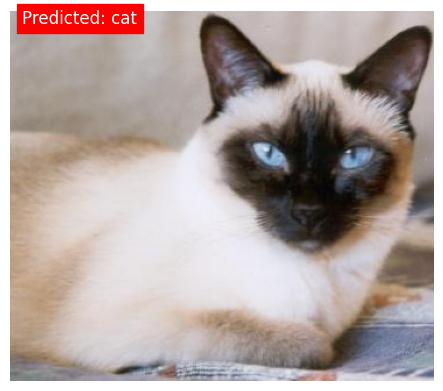

In [204]:
with torch.no_grad():
    output = model(input_batch)

_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")

import numpy as np
from PIL import Image

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()

This image most likely belongs to dog with a 99.99% confidence.


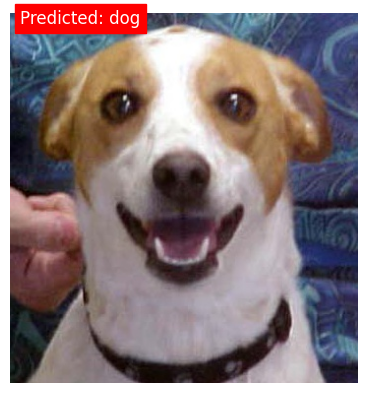

In [205]:
image_path = './test/dog.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)


with torch.no_grad():
    output = model(input_batch)

_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()


This image most likely belongs to car with a 99.06% confidence.


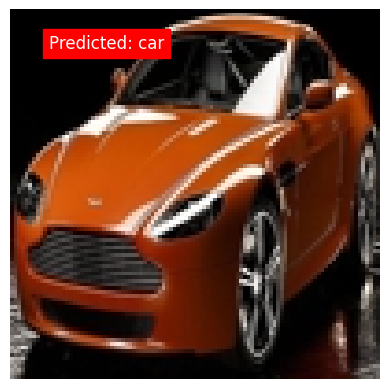

In [206]:
image_path = './test/car.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)


with torch.no_grad():
    output = model(input_batch)

_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()


In [176]:
import torchvision.models as models

googlenet = models.googlenet(pretrained=True)

num_classes = 3

googlenet.fc = nn.Linear(googlenet.fc.in_features, num_classes)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
googlenet = googlenet.to(device)


In [189]:


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

data_dir = 'data'
dataset = ImageFolder(data_dir, transform)

data_loader = DataLoader(dataset, batch_size=41, shuffle=True)


In [190]:
googlenet.eval()

for inputs, labels in data_loader:
    inputs = inputs.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    googlenet.to(inputs.device)

    with torch.no_grad():
        outputs = googlenet(inputs)

    _, preds = torch.max(outputs, 1)


In [199]:
num_epochs = 3

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(googlenet.parameters())

googlenet.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    train_acc = 0.0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = googlenet(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        acc = accuracy(outputs, labels)
        train_acc += acc.item() * inputs.size(0)

        train_loss += loss.item() * inputs.size(0)



    epoch_loss = train_loss / len(data_loader.dataset)
    epoch_acc = train_acc / len(data_loader.dataset)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")



Epoch 1/3, Loss: 0.0177, Accuracy: 0.9937
Epoch 2/3, Loss: 0.0281, Accuracy: 0.9842
Epoch 3/3, Loss: 0.0269, Accuracy: 0.9937


This image most likely belongs to dog with a 100.00% confidence.


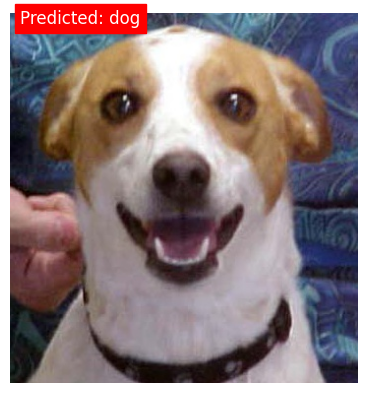

In [200]:
image_path = './test/dog.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)

googlenet.eval()
with torch.no_grad():
    output = googlenet(input_batch)

_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")

image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()


This image most likely belongs to cat with a 100.00% confidence.


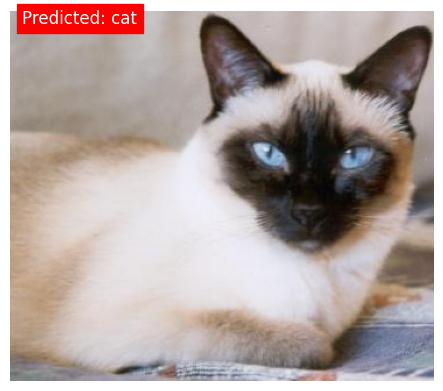

In [201]:
image_path = './test/cat.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)


with torch.no_grad():
    output = googlenet(input_batch)

_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()


This image most likely belongs to car with a 90.35% confidence.


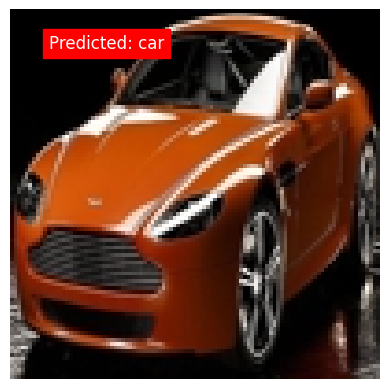

In [202]:
image_path = './test/car.jpg'
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0)


with torch.no_grad():
    output = googlenet(input_batch)

_, predicted_class = output.max(1)

predicted_class_name = class_names[predicted_class.item()]
probabilities = torch.softmax(output, dim=1)
confidence = torch.max(probabilities).item()
print(f"This image most likely belongs to {predicted_class_name} with a {confidence*100:.2f}% confidence.")


image = np.array(image)
plt.imshow(image)
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name}', fontsize=12, color='white', backgroundcolor='red')
plt.show()


Custom CNN and GoogleNet have similar accuracy, but GoogleNet is faster.
* Custom CNN: 0.9960
* GoogleNet: 0.9937

GoogleNet also predicts with higher confidence